In [13]:
# Chaitra Pirisingula
# Shruti Pradeep
# 04/10/2023 

In [14]:
from sklearn.cluster import KMeans
from skimage.color import rgb2lab
from scipy.spatial.distance import euclidean
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [15]:
# This matrix simulates protanopia, one of the most common forms of color blindness
protanopia_simulation_matrix = np.array([[0.567, 0.433, 0],
                                [0.558, 0.442, 0],
                                [0, 0.242, 0.758]])

# This matrix simulates deuteranopia, another common form of color blindness
deuteranopia_simulation_matrix = np.array([[0.625, 0.375, 0],
                                [0.7, 0.3, 0],
                                [0, 0.3, 0.7]])

# This matrix simulates tritanopia, a rare form of color blindness
tritanopia_simulation_matrix = np.array([[0.95, 0.05, 0],
                                [0, 0.433, 0.567],
                                [0, 0.475, 0.525]])

cb_masks = [protanopia_simulation_matrix, deuteranopia_simulation_matrix, tritanopia_simulation_matrix]
cb_names = ["Protanopia", "Deuteranopia", "Tritanopia"]

In [16]:
# Apply color blindness simulation matrix to image
def simulate_colorblindness(cb_simulation_matrix, image):
    cb_image = cv2.transform(image, cb_simulation_matrix)
    return cb_image

In [17]:
# Convert RGB color to its corresponding HEX value
def rgb_to_hex(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [18]:
# Get colors present in image and display pie chart of colors with occurences
def get_colors(image, number_of_colors, name):
    
    # Resize image for consistency 
    resized_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    resized_image = resized_image.reshape(resized_image.shape[0]*resized_image.shape[1], 3)
    
    # Use KMeans clustering to find colors in image
    clf = KMeans(n_clusters = number_of_colors, n_init=10)
    labels = clf.fit_predict(resized_image)
    
    counts = Counter(labels)
    
    # Define colors, hex labels, and sort by occurences
    center_colors = clf.cluster_centers_
    ordered_colors = [center_colors[i]/255 for i in counts.keys()]
    hex_colors = [rgb_to_hex(color*255) for color in ordered_colors]
    rgb_colors = [color*255 for color in ordered_colors]
    
    # Show image 
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    ax = axes[0]
    ax.imshow(image)
    ax.set_title("Image")
    
    # Show color scheme as pie chart
    ax = axes[1]
    ax.pie(counts.values(), labels = hex_colors, colors = ordered_colors)
    ax.set_title("Color Palette")

    fig.subplots_adjust(wspace=.07) 
    fig.suptitle(name, y=.95, fontsize=20)
    plt.subplots_adjust(top=0.90, bottom=0.65)
    plt.show()
    
    return rgb_colors

In [19]:
# Calculate Delta E for all colors in the original image transformed to each type of colorblindness 
# Lower Delta E -> more similar
def get_similarity_scores(colors):
    cb_similarities = defaultdict(list)
    for ind, mask in enumerate(cb_masks):
        for i in range(len(colors)):
            c1 = colors[i][::]
            # Transform original colors to colors in colorblind palettes
            color1 = cv2.transform(c1.reshape(1, 1, -1), mask)[0][0]
        
            for j in range(i + 1, len(colors)):
                c2 = colors[j][::]
                color2 = cv2.transform(c2.reshape(1, 1, -1), mask)[0][0]
              
                # Calculate difference using ΔE = √(L*₁-L*₂)² + (a*₁-a*₂)² + (b*₁-b*₂)²
                delta_e = euclidean(rgb2lab(color1/255), rgb2lab(color2/255))
                delta_e_og = euclidean(rgb2lab(colors[i][::]/255), rgb2lab(colors[j][::]/255))

                cb_similarities[cb_names[ind]].append((delta_e, delta_e_og, color1, color2, colors[i], colors[j]))
        
        # Sort from lowest to highest delta e
        cb_similarities[cb_names[ind]].sort()
    return cb_similarities

In [20]:
# Display similarity charts for most similar colors 
def display_charts(cb, scores):
    top_scores = scores[:12] 
    fig, axes = plt.subplots(4, 6, figsize=(10, 10))
    count = 0
    for score, score_og, color1, color2, c1_og, c2_og in top_scores:
        ax = axes[count // 6, count % 6]
        
        # Colors with delta e for colorblind type
        ax.pie([50, 50], labels = [rgb_to_hex(color1), rgb_to_hex(color2)], colors = [color1/255, color2/255])
        ax.set_title("Simulated: " + str(round(score, 3)), fontsize=8)

        count += 1

        ax = axes[count // 6, count % 6]

        # Colors with delta e from original 
        ax.pie([50, 50], labels = [rgb_to_hex(c1_og), rgb_to_hex(c2_og)], colors = [c1_og/255, c2_og/255])
        ax.set_title("Original: " + str(round(score_og, 3)), fontsize=8)

        count += 1

    fig.subplots_adjust(wspace=.2) 
    fig.suptitle(cb, y=.95, fontsize=20)
    plt.subplots_adjust(top=0.90, bottom=0.40)
    plt.show()

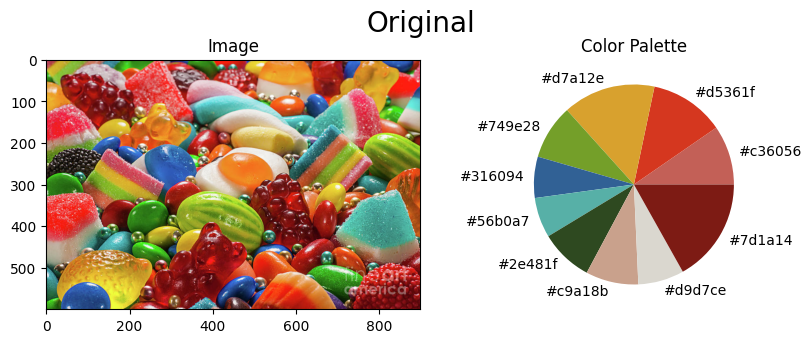

In [21]:
# Load original image
image = cv2.imread('images/candy.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get original colors and corresponding colorblindness colors with delta e scores
original_colors = get_colors(image, 10, "Original")
cb_scores = get_similarity_scores(original_colors)

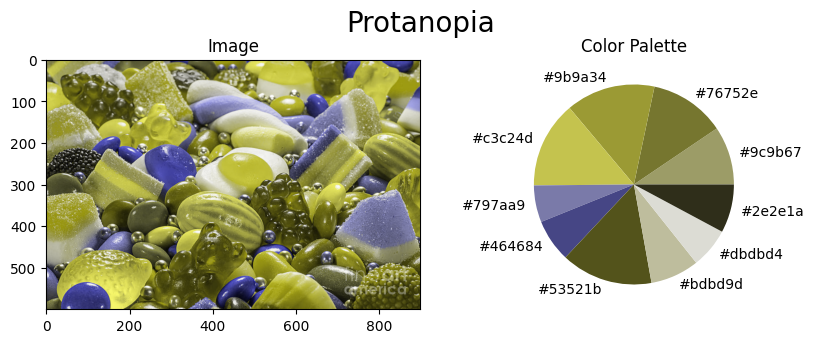

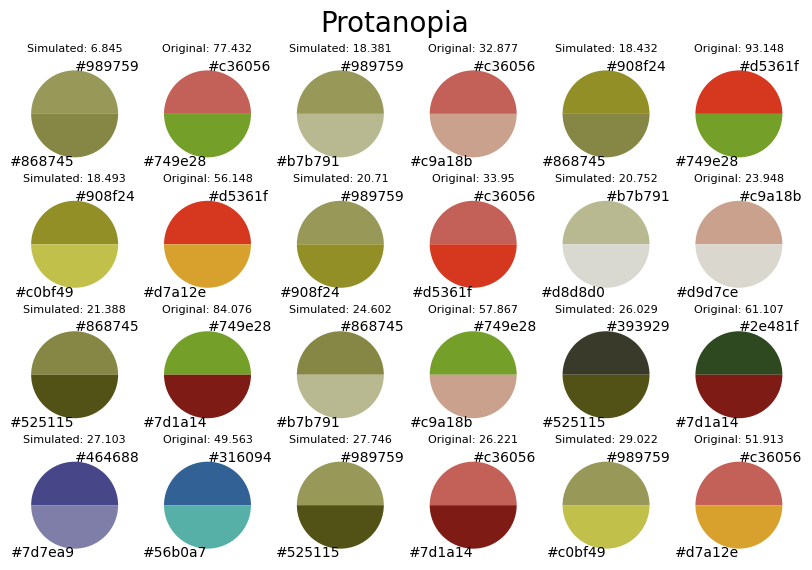

In [22]:
protanopia_image = simulate_colorblindness(protanopia_simulation_matrix, image)
protanopia_colors = get_colors(protanopia_image, 10, cb_names[0])
display_charts(cb_names[0], cb_scores[cb_names[0]])

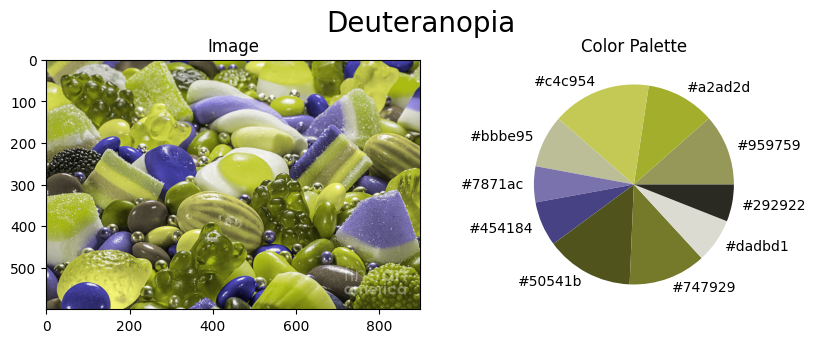

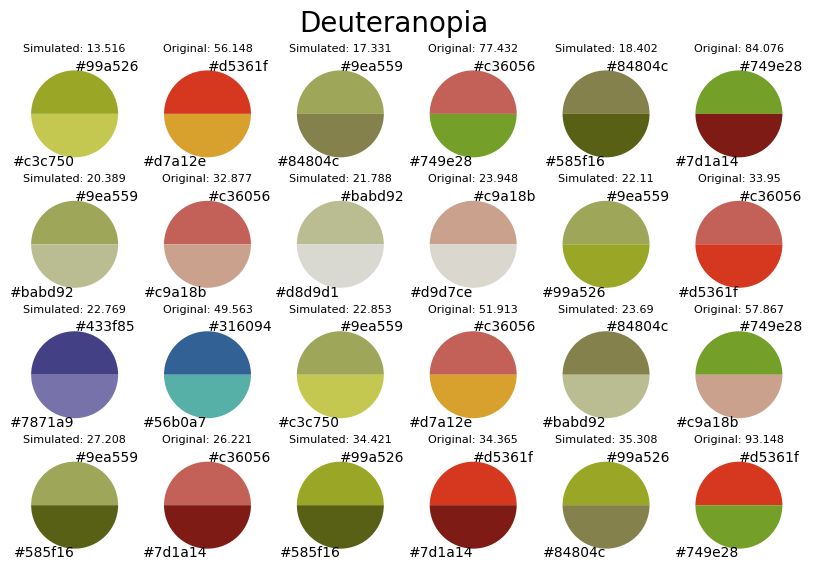

In [23]:
deuteranopia_image = simulate_colorblindness(deuteranopia_simulation_matrix, image)
deuteranopia_colors = get_colors(deuteranopia_image, 10, cb_names[1])
display_charts(cb_names[1], cb_scores[cb_names[1]])

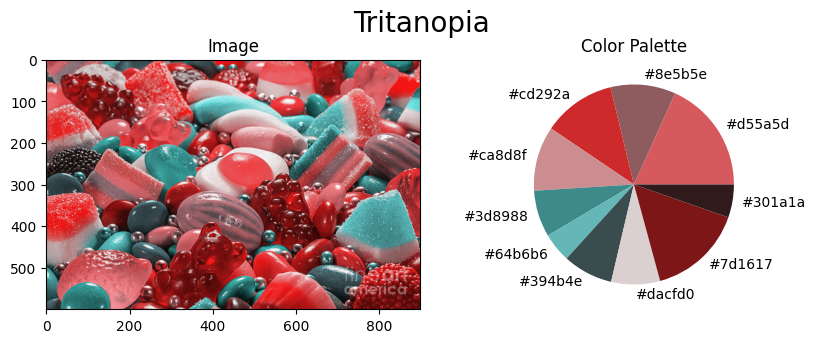

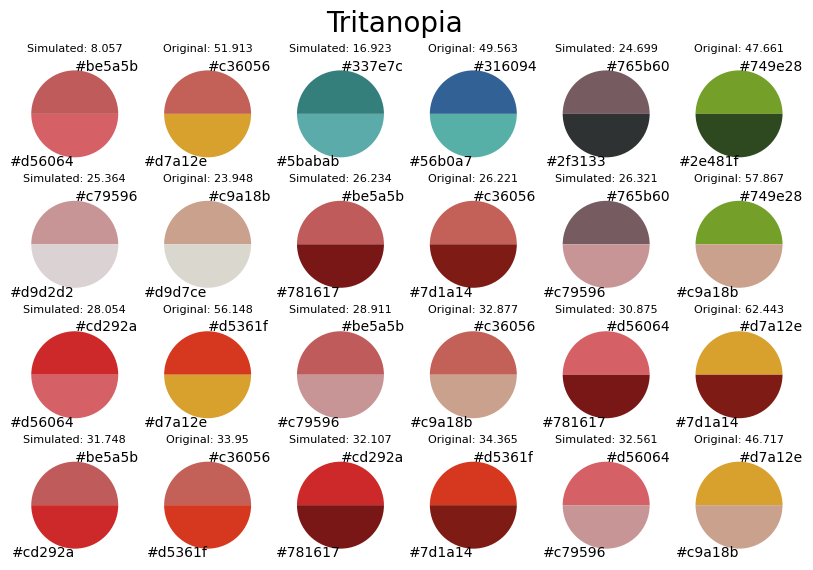

In [24]:
tritanopia_image = simulate_colorblindness(tritanopia_simulation_matrix, image)
tritanopia_colors = get_colors(tritanopia_image, 10, cb_names[2])
display_charts(cb_names[2], cb_scores[cb_names[2]])